<h1 style="font-family:verdana;"> <center>Yoga Poses Classification using Deep Convolutional Neural Networks and Transfer Learning</center> </h1>



## Yoga Pose Classification Overview
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">Yoga is a systematic practice of physical exercise, breath control, relaxation, diet control, positive thinking, and meditation aimed at developing harmony in the body, mind, and environment. The practice entails low-impact physical activity, postures (called asanas), breathing techniques (pranayama), relaxation, and meditation. Most people are familiar with the physical poses or yoga positions but don't know that yoga involves so much more. <a href='https://www.emedicinehealth.com/yoga/article_em.htm'>Source</a></p>


***

# 🏗️Import Necessary Libraries

In [2]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

# Create helper functions

In [3]:


# Import series of helper functions for our  notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

# 📥Load and transform data

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

In [5]:
# Walk through each directory
dataset = "F:\Work\Homies\ANIKET\Minor\Yoga Classification\yoga-posture-dataset"
walk_through_dir(dataset)

There are 47 directories and 1 images in 'F:\Work\Homies\ANIKET\Minor\Yoga Classification\yoga-posture-dataset'.
There are 0 directories and 74 images in 'F:\Work\Homies\ANIKET\Minor\Yoga Classification\yoga-posture-dataset\Adho Mukha Svanasana'.
There are 0 directories and 65 images in 'F:\Work\Homies\ANIKET\Minor\Yoga Classification\yoga-posture-dataset\Adho Mukha Vrksasana'.
There are 0 directories and 18 images in 'F:\Work\Homies\ANIKET\Minor\Yoga Classification\yoga-posture-dataset\Alanasana'.
There are 0 directories and 71 images in 'F:\Work\Homies\ANIKET\Minor\Yoga Classification\yoga-posture-dataset\Anjaneyasana'.
There are 0 directories and 59 images in 'F:\Work\Homies\ANIKET\Minor\Yoga Classification\yoga-posture-dataset\Ardha Chandrasana'.
There are 0 directories and 96 images in 'F:\Work\Homies\ANIKET\Minor\Yoga Classification\yoga-posture-dataset\Ardha Matsyendrasana'.
There are 0 directories and 13 images in 'F:\Work\Homies\ANIKET\Minor\Yoga Classification\yoga-posture-da

# 📅Placing data into a Dataframe
The first column `filepaths` contains the file path location of each individual images. The second column `labels`, on the other hand, contains the class label of the corresponding image from the file path

In [6]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [7]:
image_df

Filepath                 Label
0     F:\Work\Homies\ANIKET\Minor\Yoga Classificatio...  Adho Mukha Svanasana
1     F:\Work\Homies\ANIKET\Minor\Yoga Classificatio...        Ardha Navasana
2     F:\Work\Homies\ANIKET\Minor\Yoga Classificatio...       Baddha Konasana
3     F:\Work\Homies\ANIKET\Minor\Yoga Classificatio...       Baddha Konasana
4     F:\Work\Homies\ANIKET\Minor\Yoga Classificatio...       Baddha Konasana
...                                                 ...                   ...
4705  F:\Work\Homies\ANIKET\Minor\Yoga Classificatio...             Vrksasana
4706  F:\Work\Homies\ANIKET\Minor\Yoga Classificatio...             Vrksasana
4707  F:\Work\Homies\ANIKET\Minor\Yoga Classificatio...             Vrksasana
4708  F:\Work\Homies\ANIKET\Minor\Yoga Classificatio...             Vrksasana
4709  F:\Work\Homies\ANIKET\Minor\Yoga Classificatio...             Vrksasana

[4710 rows x 2 columns]

# 🔭Visualizing images from the dataset

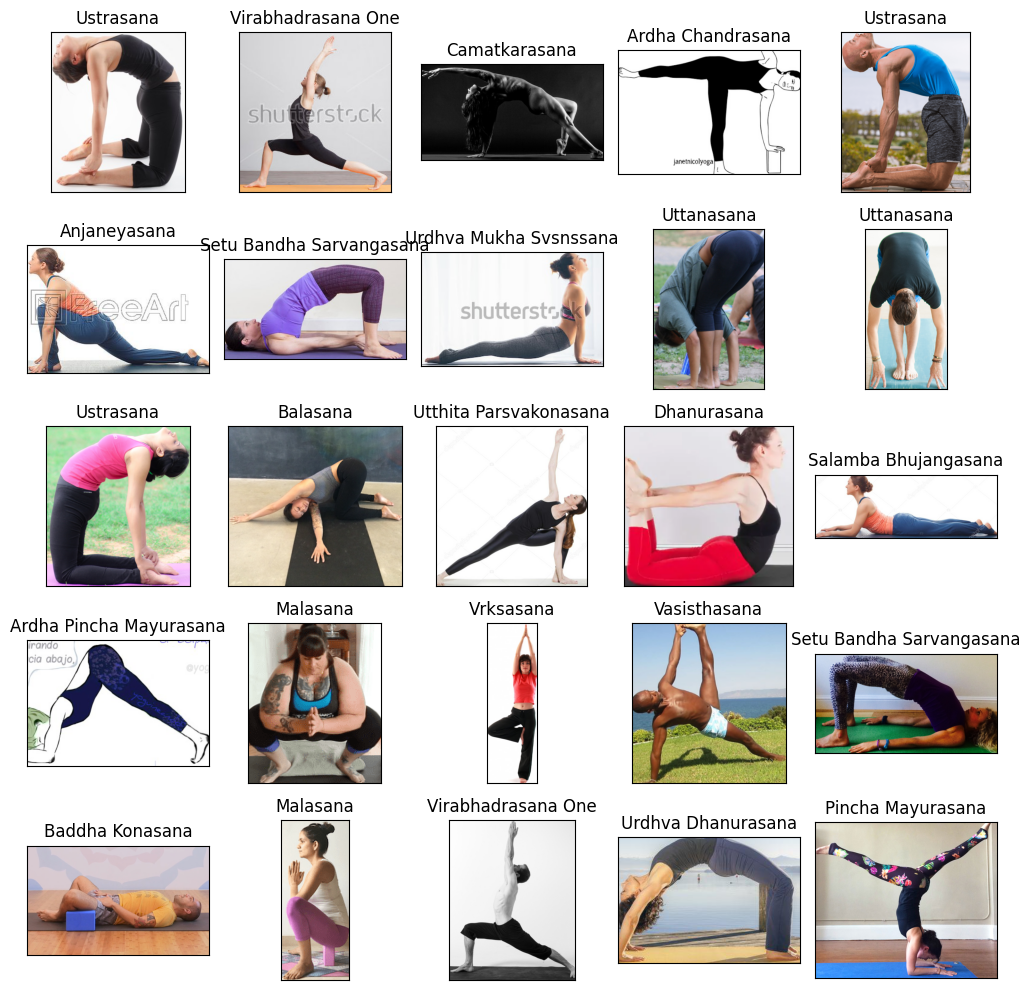

In [8]:
# Display 9 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 26)
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

# 🧮Computing Error Rate Analysis

In [9]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

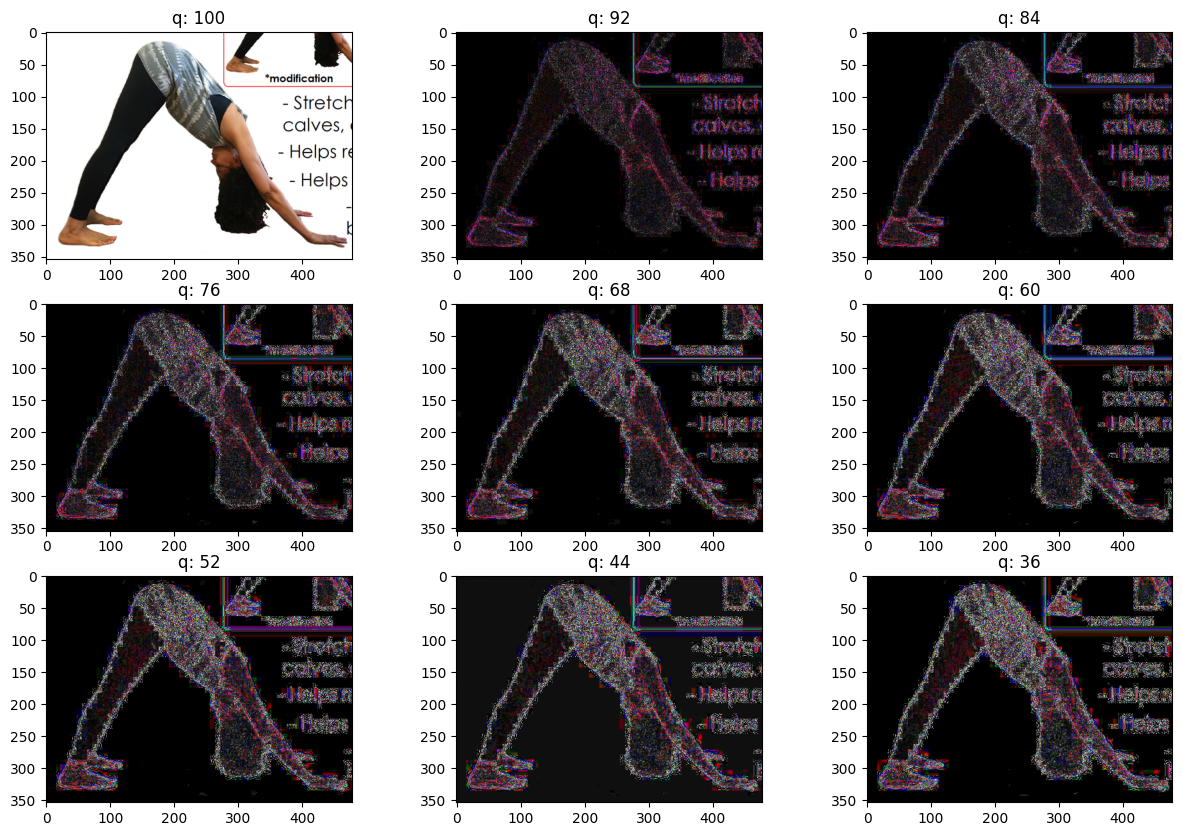

In [10]:
# View random sample from the dataset
p = random_sample('F:\Work\Homies\ANIKET\Minor\Yoga Classification\yoga-posture-dataset\Adho Mukha Svanasana')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

# 📝Data Preprocessing
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">The data will be split into three different categories: Training, Validation and Testing. The training data will be used to train the deep learning CNN model and its parameters will be fine tuned with the validation data. Finally, the performance of the data will be evaluated using the test data(data the model has not previously seen).</p>

In [11]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=1)

In [12]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

In [13]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3015 validated image filenames belonging to 43 classes.
Found 753 validated image filenames belonging to 43 classes.
Found 942 validated image filenames belonging to 42 classes.


In [14]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Setup data augmentation
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal_and_vertical"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),                       
], name="data_augmentation")

# 🤹Training the model
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">The model images will be subjected to a pre-trained CNN model called MobileNetV2. Three callbacks will be utilized to monitor the training. These are: Model Checkpoint, Early Stopping, Tensorboard callback. The summary of the model hyperparameter is shown as follows:</p>

**Batch size** : 32

**Epochs** : 100

**Input Shape** : (224, 224, 3)

**Output layer** : 43



In [15]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [16]:
# Create checkpoint callback
checkpoint_path = "yoga_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [17]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3,
                                                  restore_best_weights=True) # if val loss decreases for 3 epochs in a row, stop training

# 🚄Train the model

In [18]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)
x = data_augmentation(x)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(43, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "yoga_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/yoga_classification/20240408-005412
Epoch 1/100
13/95 [===>..........................] - ETA: 15s - loss: 4.0936 - accuracy: 0.0288

D:\Anaconda\envs\TTL_Project\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


95/95 [==============================] - 31s 211ms/step - loss: 4.0116 - accuracy: 0.0262 - val_loss: 3.8454 - val_accuracy: 0.0319
Epoch 2/100
95/95 [==============================] - 18s 186ms/step - loss: 3.9098 - accuracy: 0.0312 - val_loss: 3.7606 - val_accuracy: 0.0412
Epoch 3/100
95/95 [==============================] - 18s 187ms/step - loss: 3.8180 - accuracy: 0.0395 - val_loss: 3.6972 - val_accuracy: 0.0505
Epoch 4/100
95/95 [==============================] - 17s 183ms/step - loss: 3.7517 - accuracy: 0.0454 - val_loss: 3.6470 - val_accuracy: 0.0637
Epoch 5/100
95/95 [==============================] - 18s 185ms/step - loss: 3.6952 - accuracy: 0.0491 - val_loss: 3.6013 - val_accuracy: 0.0730
Epoch 6/100
95/95 [==============================] - 18s 191ms/step - loss: 3.6474 - accuracy: 0.0657 - val_loss: 3.5587 - val_accuracy: 0.0837
Epoch 7/100
95/95 [==============================] - 18s 195ms/step - loss: 3.6025 - accuracy: 0.0683 - val_loss: 3.5195 - val_accuracy: 0.0903
Epoc

# ✔️Model Evaluation
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">The test dataset will be used to evaluate the performance of the model.One of the metrics that will be tested would be accuracy which measures the fraction of predictions the model got right. Other metrics are as follows:   </p>

<h3>Precision(P):</h3> 
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">The fraction of true positives (TP, correct predictions) from the total amount of relevant results, i.e., the sum of TP and false positives (FP). For multi-class classification problems, P is averaged among the classes. The following is the formula for precision.</p>

<h4> <center>$P=TP/(TP+FP)$</center></h4> 

<h3>Recall(R): </h3> 
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">The fraction of TP from the total amount of TP and false negatives (FN). For multi-class classification problems, R gets averaged among all the classes. The following is the formula for recall.</p>
<h4><center>$R=TP/(TP+FN)$</center></h4>

<h3>F1 score(F1): </h3>

<p style="font-size:15px; font-family:verdana; line-height: 1.7em">The harmonic mean of precision and recall. For multi-class classification problems, F1 gets averaged among all the classes. The following is the formula for F1 score.</p>
<h4><center>$F1=2 * (TP * FP)/(TP+FP)$</center></h4>




In [30]:
import warnings
warnings.filterwarnings('ignore')

In [33]:
history.history

{'loss': [4.011559009552002,
  3.9098398685455322,
  3.817983388900757,
  3.7516872882843018,
  3.695162773132324,
  3.647371530532837,
  3.6024606227874756,
  3.55765700340271,
  3.496673822402954,
  3.455030918121338,
  3.425429582595825,
  3.3778979778289795,
  3.329207420349121,
  3.310988664627075,
  3.276169538497925,
  3.220404863357544,
  3.1842520236968994,
  3.1143410205841064,
  3.0993049144744873,
  3.0458264350891113,
  3.0076284408569336,
  2.956437587738037,
  2.9157660007476807,
  2.8758385181427,
  2.8369076251983643,
  2.8084185123443604,
  2.741460084915161,
  2.7031142711639404,
  2.67063045501709,
  2.6109282970428467,
  2.581329584121704,
  2.5340383052825928,
  2.510779857635498,
  2.442638397216797,
  2.424750804901123,
  2.3961052894592285,
  2.336984395980835,
  2.317667007446289,
  2.2796096801757812,
  2.246731758117676,
  2.1871097087860107,
  2.1714181900024414,
  2.1303133964538574,
  2.1170027256011963,
  2.0603058338165283,
  2.0331766605377197,
  1.999

# 📉Visualizing loss curves

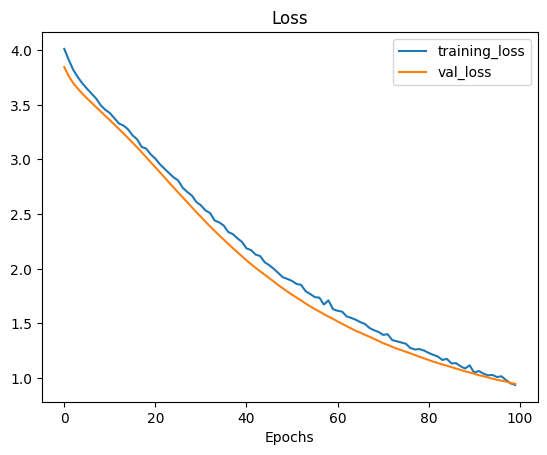

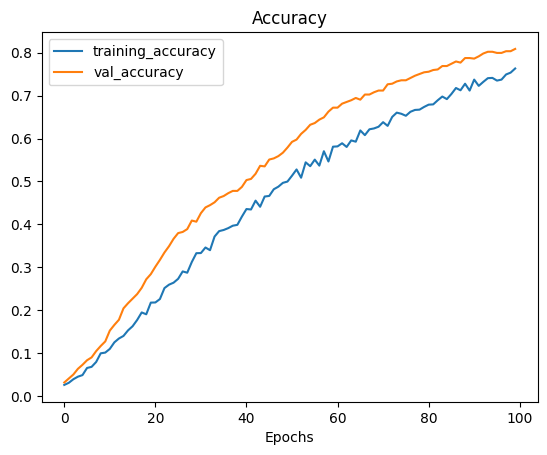

In [20]:
plot_loss_curves(history)

# 🔮Making predictions on the test data

In [21]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

30/30 [==============================] - 6s 173ms/step
The first 5 predictions: ['Halasana', 'Ardha Pincha Mayurasana', 'Virabhadrasana One', 'Malasana', 'Salamba Bhujangasana']


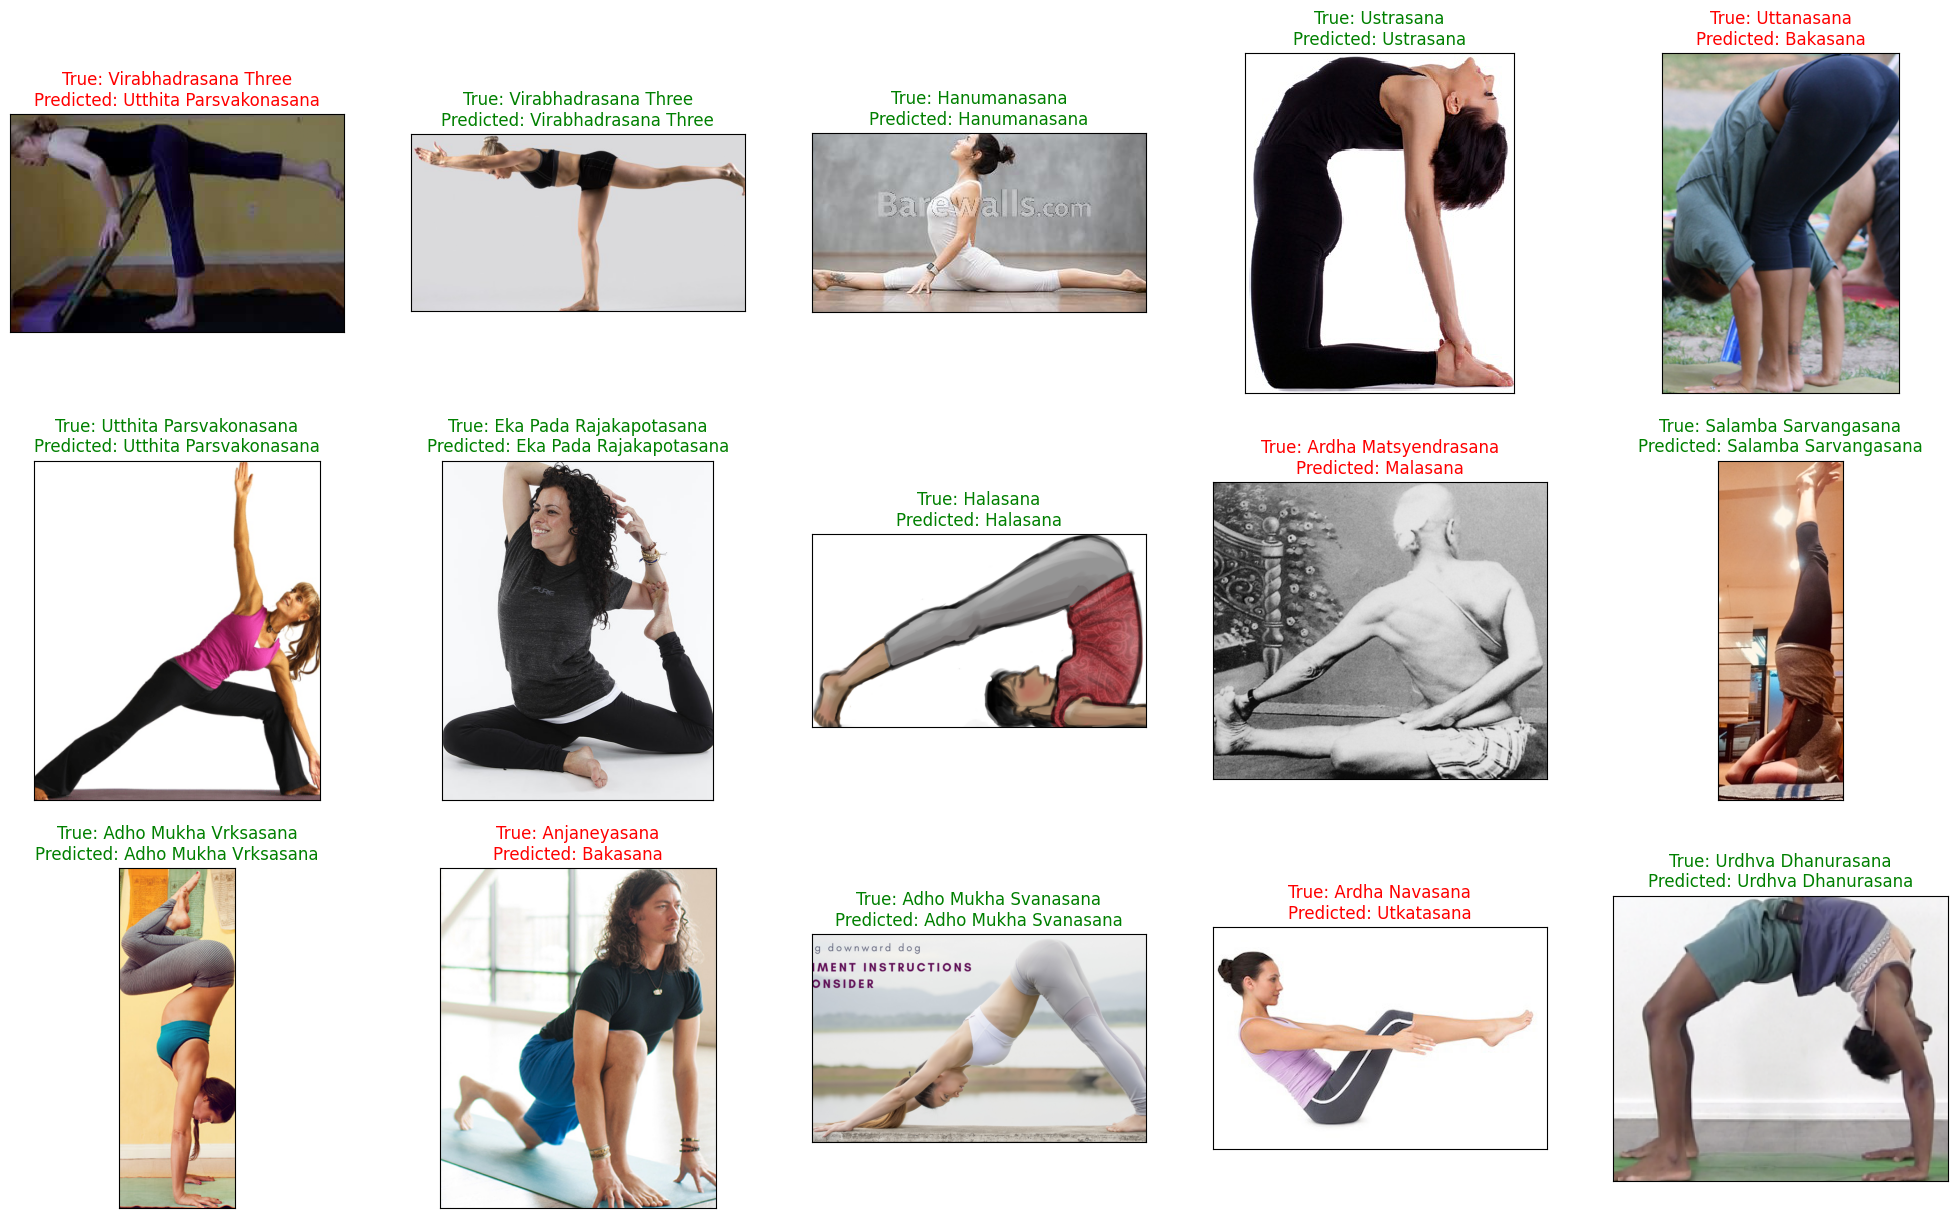

<Figure size 640x480 with 0 Axes>

In [22]:
  # Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 50)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

# 📊Plotting the classification reports and confusion matrix

In [25]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                               precision    recall  f1-score   support

         Adho Mukha Svanasana       0.78      0.85      0.82        34
         Adho Mukha Vrksasana       0.72      0.75      0.73        24
                    Alanasana       0.00      0.00      0.00         2
                 Anjaneyasana       0.57      0.36      0.44        22
            Ardha Chandrasana       0.81      0.85      0.83        20
         Ardha Matsyendrasana       0.76      0.76      0.76        41
               Ardha Navasana       0.00      0.00      0.00         4
      Ardha Pincha Mayurasana       0.56      0.60      0.58        15
            Ashta Chandrasana       0.00      0.00      0.00         1
              Baddha Konasana       0.65      0.79      0.71        19
                     Bakasana       0.80      0.85      0.82        33
                     Balasana       0.84      0.78      0.81        27
                   Bitilasana       0.68      0.88      0.77        34
     

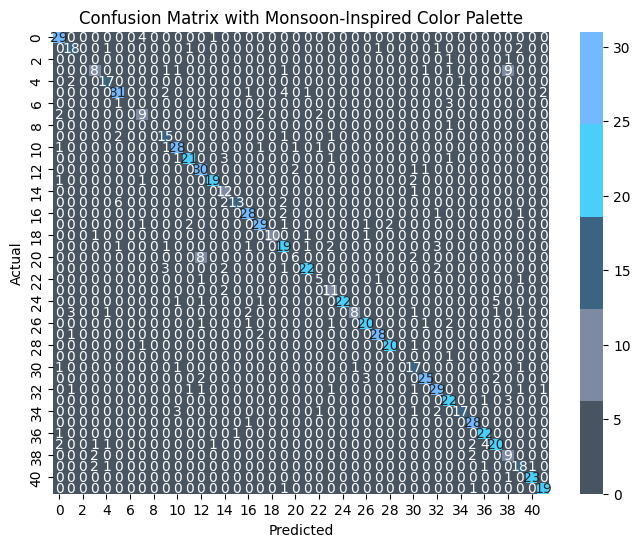

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define your confusion matrix data (y_test and pred)
# Assuming you already have defined y_test and pred

# Define the monsoon-inspired color palette
monsoon_palette = ["#485460", "#7E8AA2", "#3C6382", "#4BCFFA", "#74B9FF"]

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# Plot confusion matrix with monsoon-inspired color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=monsoon_palette)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Monsoon-Inspired Color Palette')
plt.show()

In [26]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score     support
Adho Mukha Svanasana            0.783784  0.852941  0.816901   34.000000
Adho Mukha Vrksasana            0.720000  0.750000  0.734694   24.000000
Alanasana                       0.000000  0.000000  0.000000    2.000000
Anjaneyasana                    0.571429  0.363636  0.444444   22.000000
Ardha Chandrasana               0.809524  0.850000  0.829268   20.000000
Ardha Matsyendrasana            0.756098  0.756098  0.756098   41.000000
Ardha Navasana                  0.000000  0.000000  0.000000    4.000000
Ardha Pincha Mayurasana         0.562500  0.600000  0.580645   15.000000
Ashta Chandrasana               0.000000  0.000000  0.000000    1.000000
Baddha Konasana                 0.652174  0.789474  0.714286   19.000000
Bakasana                        0.800000  0.848485  0.823529   33.000000
Balasana                        0.840000  0.777778  0.807692   27.000000
Bitilasana                      0.681818  0.882353  0.769231   34.000000
Camatkarasana                   0.904762  0.826087  0.863636   23.000000
Dhanurasana                     0.571429  0.923077  0.705882   13.000000
Eka Pada Rajakapotasana         0.928571  0.565217  0.702703   23.000000
Garudasana                      0.823529  0.875000  0.848485   32.000000
Halasana                        0.828571  0.805556  0.816901   36.000000
Hanumanasana                    1.000000  0.769231  0.869565   13.000000
Malasana                        0.593750  0.678571  0.633333   28.000000
Marjaryasana                    0.666667  0.375000  0.480000   16.000000
Padmasana                       0.880000  0.733333  0.800000   30.000000
Parsvottanasana                 0.555556  0.625000  0.588235    8.000000
Paschimottanasana               0.647059  0.846154  0.733333   13.000000
Phalakasana                     1.000000  0.733333  0.846154   30.000000
Pincha Mayurasana               0.888889  0.470588  0.615385   17.000000
Salamba Bhujangasana            0.800000  0.769231  0.784314   26.000000
Salamba Sarvangasana            0.933333  0.903226  0.918033   31.000000
Setu Bandha Sarvangasana        0.909091  0.909091  0.909091   22.000000
Supta Kapotasana                0.000000  0.000000  0.000000    1.000000
Urdhva Dhanurasana              0.629630  0.809524  0.708333   21.000000
Urdhva Mukha Svsnssana          0.892857  0.781250  0.833333   32.000000
Ustrasana                       0.763158  0.805556  0.783784   36.000000
Utkatasana                      0.687500  0.846154  0.758621   26.000000
Uttanasana                      0.944444  0.708333  0.809524   24.000000
Utthita Hasta Padangusthasana   0.848485  0.965517  0.903226   29.000000
Utthita Parsvakonasana          0.785714  0.916667  0.846154   24.000000
Vasisthasana                    0.714286  0.645161  0.677966   31.000000
Virabhadrasana One              0.391304  0.692308  0.500000   13.000000
Virabhadrasana Three            0.720000  0.782609  0.750000   23.000000
Virabhadrasana Two              0.958333  0.958333  0.958333   24.000000
Vrksasana                       0.863636  0.904762  0.883721   21.000000
accuracy                        0.771762  0.771762  0.771762    0.771762
macro avg                       0.697807  0.692729  0.685829  942.000000
weighted avg                    0.780413  0.771762  0.767880  942.000000

# ☀️Grad-Cam Visualization

**Source code inspiration can be found [here](https://www.kaggle.com/code/databeru/visual-explanations-from-deep-networks-grad-cam)**

In [27]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return cam_path
    

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "Conv_1"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

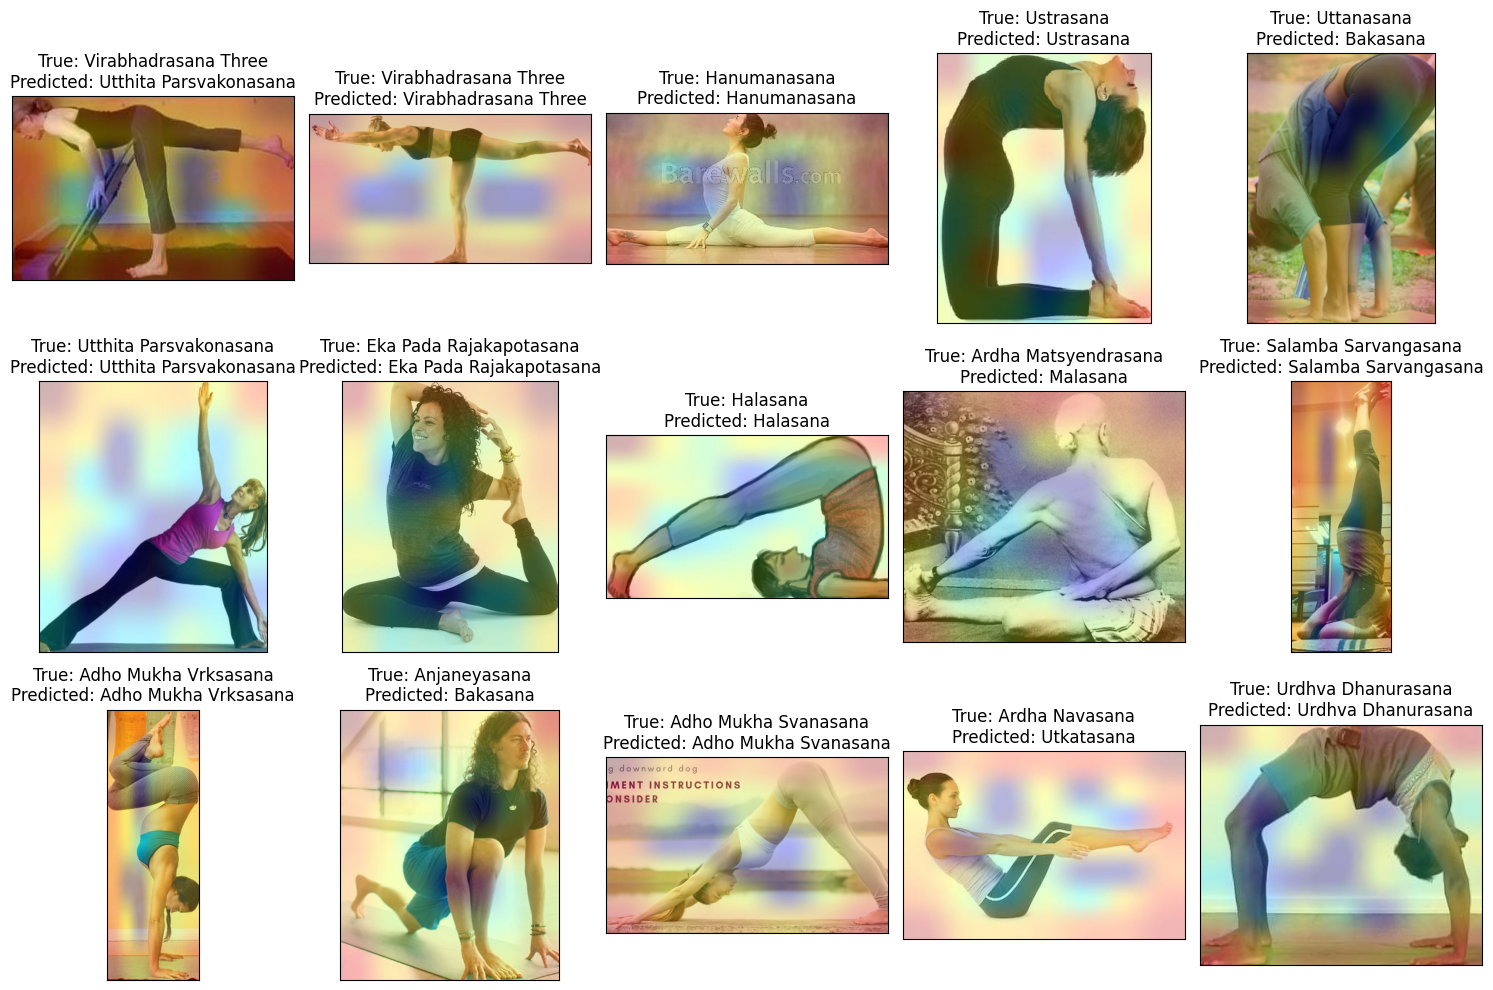

In [28]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()